# Instructions and Remarks #

*   Download this Jupyter Notebook and upload it on google drive. Then, open and run via google collab.
*   A large dataset will be downloaded for this project. Among the data, you may choose the number of samplongs that you may use when running the notebook.

# Objective #


1.   First, we will collect various samples of the COCO dataset and filter out the nouns for each sample.
2.   Then, we will filter out the nouns and compare it with each other, and measure the cosine similarity.
3. We will then show a graphical representation of how similar the items are.

![alt text](https://miro.medium.com/max/442/1*UODvtQMybHE8c0eL3K5z5A.png)


   4.  We will then proceed to use the training samples and predict how well the nouns are predicted, with the information of how "similar" the nouns are, which we retrieved from finding the cosine similarity.
   5. We will also show a graphical representation of such, to draw conclusions.


![alt text](https://miro.medium.com/max/886/1*yiH5sZI-IBxDSQMKhvbcHw.png)

# Import Statements #

We will first import the appropriate modules which we will be using right now.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
print("Imported")

Imported


# Import Dataset #

We will download the COCO dataset.

> Indented block



In [6]:
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510574080/13510573713 [==============================] - 215s 0us/step


We will restrict the training size by setting up a certain limit. This case, we are using 10000 samples.

In [0]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)
num_examples = 10000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [74]:
len(train_captions)
# type(train_captions)

10000

# Extracting the **Nouns** from the Restricted Dataset

Now that we have limited the datatset for training, we will construct an algorithm so that we are able to filter out the nouns.

We wil use NLTK library, to filter out the nouns.

Incase your NTLK packages are not downloaded, this jupyter notebook will allow you to download the 'punkt' package and the 'averaged_perceptron_tagger' package. 

If you already have the NLTK libraries, comment out "nltk.download()" portion below the import statement.

In [75]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# lines = [['lines is was some string of words'], ['My name is Jeff']]

def filter_nouns(data):
    i = 0
    nouns = None
    noun_list = []
    while i < len(data):
        lines = ''.join(data[i])
        # function to test if something is a noun
        is_noun = lambda pos: pos[:2] == 'NN'
        # do the nlp stuff
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        noun_list = [*noun_list, nouns]
        i += 1     
    return noun_list
    
filter_nouns(train_captions)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[['start', 'skateboarder', 'trick', 'skateboard', 'ramp', 'end', '>'],
 ['start', 'person', 'air', 'skis', 'end', '>'],
 ['start', 'wood', 'door', 'boards', 'end', '>'],
 ['start', 'A', 'Do', 'Enter', 'sign', 'road', 'stadium', 'end', '>'],
 ['start', '>', 'Small', 'child', 'chair', 'plate', 'end', '>'],
 ['start', '>', 'groups', 'people', 'toilet', 'area', 'end', '>'],
 ['start', 'hand', 'cellphone', 'end', '>'],
 ['start', '>', 'People', 'computers', 'student', 'room', 'end', '>'],
 ['start', '>', 'birds', 'field', 'end', '>'],
 ['start', 'man', 'cell', 'phone', 'park', 'end', '>'],
 ['start', 'A', 'group', 'men', 'table', 'microphones', 'speech', 'end', '>'],
 ['start', 'bathroom', 'toilet', 'sprayer', 'wall', 'end', '>'],
 ['start', 'A', 'woman', 'bench', 'phone', 'end', '>'],
 ['start', 'woman', 'clock', 'purse', 'market', 'end', '>'],
 ['start', 'surfer', 'hand', 'signal', 'end', '>'],
 ['start', 'A', 'cat', 'asphalt', 'end', '>'],
 ['start', '>', 'carrots', 'cut', 'squash', 'car

# Observing Scene Prediciton with Cosine and Soft cosine similarity # 

## Cosine Similarity Analysis ##

*TODO*

*The captions are a list of strings, convert to a list of lists and filter our the nouns from that list -- done*

*Find the cosine similarity between the lists*

*Add a new caption, remove a noun and see if our model can predict the possible noun associated with that catption* 

With the obtained list of lists which contains the nouns for each training set, we will now calculate the cosine similarity and plot a visual representation of how similar each captions are.

We will first construct a document-term matrix. 
https://www.machinelearningplus.com/nlp/cosine-similarity/

In [0]:
# Define the bag of captions 
captions = filter_nouns(train_captions)

In [82]:
# import appropriate models
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

def construct_matrix(document):   
    # Create the Document Term Matrix
    count_vectorizer = CountVectorizer(stop_words='english')
    count_vectorizer = CountVectorizer()
    
    # Filter out components that are not needed 
    i = 0
    df = None
    noun_list = []
    while i < len(document):
        j = 0
        word_list = []
        while j < len(document[i]):
            if document[i][j] == 'start':
                document[i].remove(document[i][j])
            if document[i][j] == 'end':
                document[i].remove(document[i][j])
            if document[i][j] == '>':
                document[i].remove(document[i][j])            
            j += 1
        
        # Convert list of strings to natural language
        noun_str = ' '.join(document[i])

        noun_list = [*noun_list, noun_str]
        i += 1
    
    # Define the matrix
    sparse_matrix = count_vectorizer.fit_transform(noun_list)

    # Convert Sparse Matrix to Pandas Dataframe to see the word frequencies.
    doc_term_matrix = sparse_matrix.todense()
    
    # Label each row with the appropriate caption
    count = 0
    numbers = []
    while count < 10000:
        count += 1
        numbers = [*numbers, "Caption {}".format(len(numbers) + 1)]
    
    df = pd.DataFrame(doc_term_matrix, 
                  columns=count_vectorizer.get_feature_names(), 
                  index=[x for x in numbers]) 

    return df

matrix = construct_matrix(captions)
observations = np.shape(matrix)[0]
features = np.shape(matrix)[1]

print("The data has {} observations and {} features.".format(observations, \
                                                             features))
construct_matrix(captions)

The data has 10000 observations and 3441 features.


,51,abandon,accent,accents,accident,action,activities,ad,adult,adults,advertisement,advertiser,advertising,aeroplane,afghan,afternoon,ages,agility,ahead,air,aircraft,airline,airliner,airlines,airplane,airplanes,airport,airshow,airstrip,airy,aisle,alarm,alaska,album,alcohol,alert,alice,alien,all,allee,...,work,worker,workers,works,workshop,workspace,world,worm,woven,wrap,wrapper,wreaths,wrestling,writing,wrought,wwii,yacht,yachts,yak,yankee,yard,year,yellow,yells,yoga,yogurt,york,yound,young,younger,youth,yummy,zeberas,zebra,zebras,zebu,zipper,zone,zoo,zucchini
Caption 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Caption 2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Caption 3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Caption 4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Caption 5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Caption 9996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Caption 9997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Caption 9998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Caption 9999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now that we have successfully generated a document term matrix, we will compute the cosine similarity and display the output, using sklearn.metrics.

In [83]:
# Compute Cosine Similarity
from sklearn.metrics.pairwise import cosine_similarity

cos_sim = cosine_similarity(matrix, matrix)
# print(np.shape(cos_sim))
print(cos_sim)

# [[1.         0.51480485 0.38890873]
#  [0.51480485 1.         0.38829014]
#  [0.38890873 0.38829014 1.        ]]

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


We will visualise this computed cosine similarity matrix by clustering in terms of k-means.

Before that, we will do a principle component analysis to reduce the dimensions of the data, and find the optimal clusters.

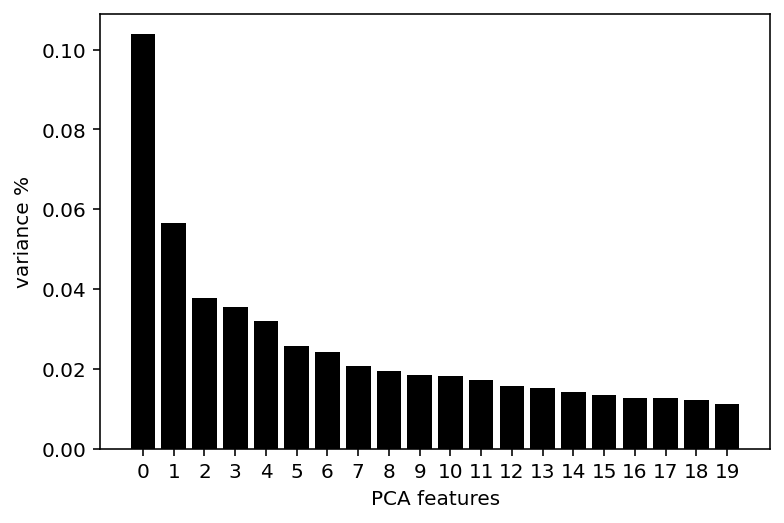

In [101]:
# Imports
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%config InlineBackend.figure_format='retina'

# Load in the data
df = cosine_similarity(matrix, matrix)
# Standardize the data to have a mean of ~0 and a variance of 1
X_std = StandardScaler().fit_transform(df)
# Create a PCA instance: pca
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(X_std)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

Here we see a variance drop after the first component.

Text(0, 0.5, 'PCA 2')

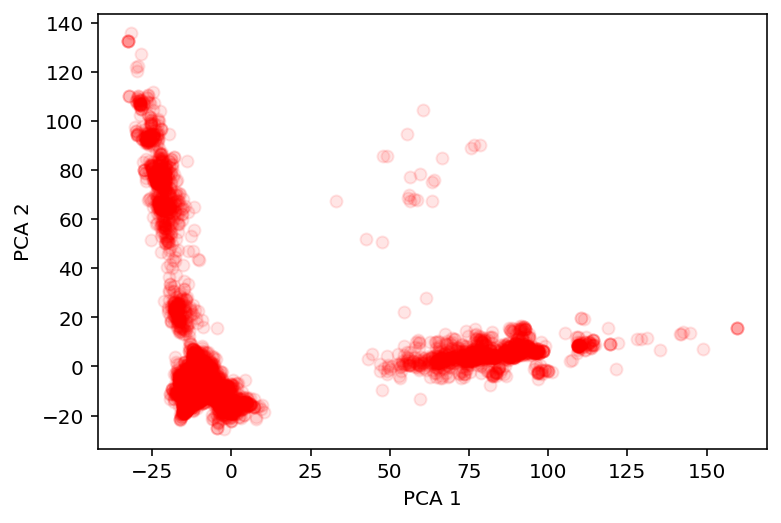

In [100]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='red')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

We must find the sum of squared distances of samples to their closest cluster center to determine the optimal clustering.

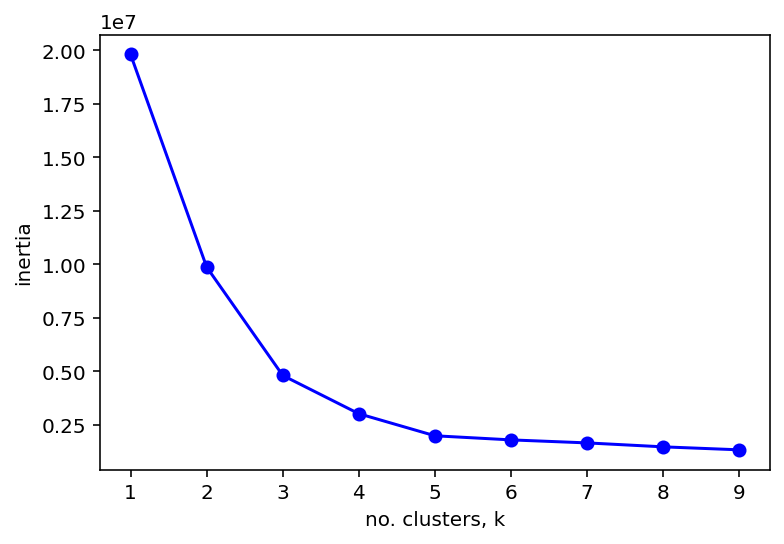

In [98]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='blue')
plt.xlabel('no. clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

We see an elbow point at around 2 clusters. We will use 2 clusters as our optimal number of clusters.

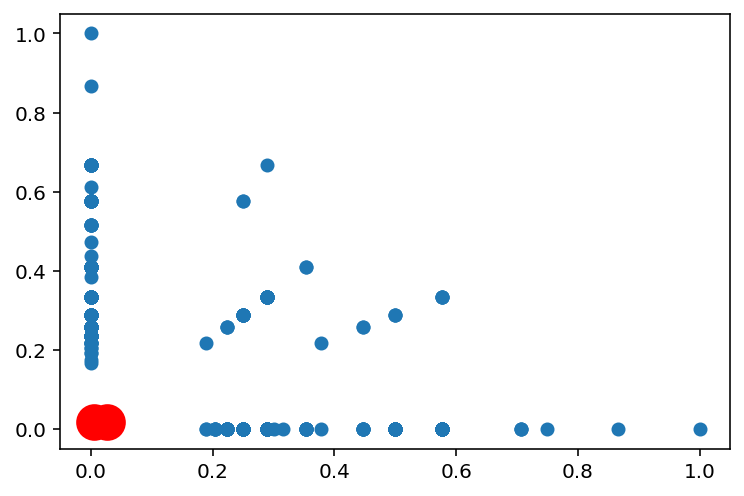

In [99]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(df)
plt.scatter(df[:,0], df[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

## Matthew edit this box and please write the analysis here. ##

## Predicting Nouns by adding a new Caption and removing a Noun ##

*Add a new caption, remove a noun and see if our model can predict the possible noun associated with that catption* 

## Cosine Similarity Ctd. - Soft Cosine Similarity Analysis ##

We have found the cosine similarity of the captions, as shown above. 

A soft cosine or ("soft" similarity) between two vectors considers similarities between pairs of features, which helps generalise the idea of cosine similiarity. 

We will take a step further and do a soft cosine similarity analysis with the same list of lists of nouns, and plot a visual representation.

In [0]:
# Define the documents
doc_soup = "Soup is a primarily liquid food, generally served warm or hot (but may be cool or cold), \
that is made by combining ingredients of meat or vegetables with stock, juice, water, or another liquid. "

doc_noodles = "Noodles are a staple food in many cultures. They are made from unleavened dough which is \
stretched, extruded, or rolled flat and cut into one of a variety of shapes."

doc_dosa = "Dosa is a type of pancake from the Indian subcontinent, made from a fermented batter. \
It is somewhat similar to a crepe in appearance. Its main ingredients are rice and black gram."

documents = [doc_trump, doc_election, doc_putin, doc_soup, doc_noodles, doc_dosa]

In [0]:
import gensim
# upgrade gensim if you can't import softcossim
from gensim.matutils import softcossim 
from gensim import corpora
import gensim.downloader as api
from gensim.utils import simple_preprocess
print(gensim.__version__)
#> '3.6.0'

# Download the FastText model
fasttext_model300 = api.load('fasttext-wiki-news-subwords-300')

3.6.0
[================================================--] 96.2% 922.1/958.4MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# Prepare a dictionary and a corpus.
dictionary = corpora.Dictionary([simple_preprocess(doc) for doc in documents])

# Prepare the similarity matrix
similarity_matrix = fasttext_model300.similarity_matrix(dictionary, tfidf=None, threshold=0.0, exponent=2.0, nonzero_limit=100)

# Convert the sentences into bag-of-words vectors.
sent_1 = dictionary.doc2bow(simple_preprocess(doc_trump))
sent_2 = dictionary.doc2bow(simple_preprocess(doc_election))
sent_3 = dictionary.doc2bow(simple_preprocess(doc_putin))
sent_4 = dictionary.doc2bow(simple_preprocess(doc_soup))
sent_5 = dictionary.doc2bow(simple_preprocess(doc_noodles))
sent_6 = dictionary.doc2bow(simple_preprocess(doc_dosa))

sentences = [sent_1, sent_2, sent_3, sent_4, sent_5, sent_6]

# Compute soft cosine similarity
print(softcossim(sent_1, sent_2, similarity_matrix))
#> 0.567228632589

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.5842470477718544


In [0]:
import numpy as np
import pandas as pd

def create_soft_cossim_matrix(sentences):
    len_array = np.arange(len(sentences))
    xx, yy = np.meshgrid(len_array, len_array)
    cossim_mat = pd.DataFrame([[round(softcossim(sentences[i],sentences[j], similarity_matrix) ,2) for i, j in zip(x,y)] for y, x in zip(xx, yy)])
    return cossim_mat

create_soft_cossim_matrix(sentences)

,0,1,2,3,4,5
0,1.00,0.58,0.56,0.28,0.34,0.40
1,0.58,1.00,0.54,0.25,0.31,0.43
2,0.56,0.54,1.00,0.19,0.25,0.36
3,0.28,0.25,0.19,1.00,0.50,0.38
4,0.34,0.31,0.25,0.50,1.00,0.56
5,0.40,0.43,0.36,0.38,0.56,1.00


# Conclusion #

*Matthew do this part*